<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/xgboost_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[  126  4935]
 [   28 19020]]
              precision    recall  f1-score   support

           0       0.82      0.02      0.05      5061
           1       0.79      1.00      0.88     19048

    accuracy                           0.79     24109
   macro avg       0.81      0.51      0.47     24109
weighted avg       0.80      0.79      0.71     24109



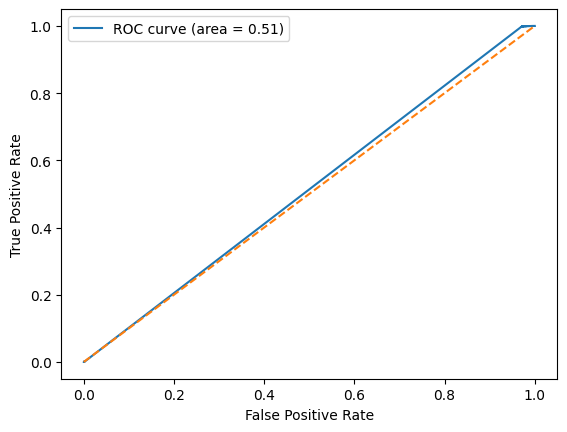

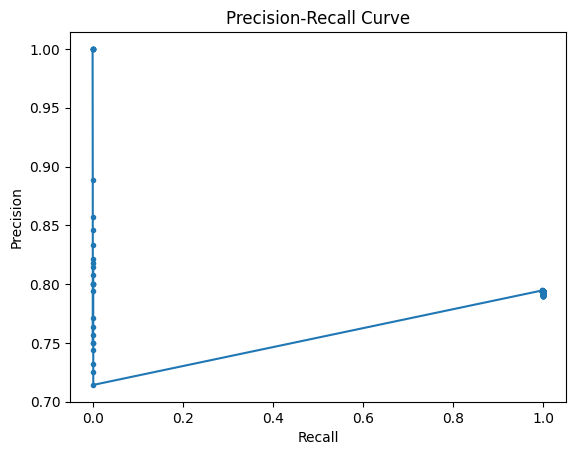

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from xgboost import XGBClassifier

# Load the files
enrollment_df = pd.read_csv('enrollment_train.csv')
log_df = pd.read_csv('log_train spliting.csv')
truth_df = pd.read_csv('truth_train.csv', header=None, names=['enrollment_id', 'dropout'])

# Preprocess log file
log_df['time'] = pd.to_datetime(log_df['time'])
min_time_per_enrollment = log_df.groupby('enrollment_id')['time'].min().reset_index().rename(columns={'time': 'start_time'})
log_df = log_df.merge(min_time_per_enrollment, on='enrollment_id')
log_df['day'] = (log_df['time'] - log_df['start_time']).dt.days + 1
log_df.drop(columns=['start_time'], inplace=True)

# Create event count per day
log_df['count'] = 1
pivot_df = log_df.pivot_table(index=['enrollment_id', 'day'], columns='event', values='count', aggfunc='sum', fill_value=0).reset_index()
pivot_wide_df = pivot_df.pivot_table(index='enrollment_id', columns='day')
pivot_wide_df.columns = [f"{event}_day{day}" for (event, day) in pivot_wide_df.columns]
pivot_wide_df = pivot_wide_df.reset_index()

# Merge all data
merged_df = enrollment_df.merge(truth_df, on='enrollment_id', how='left')
final_df = merged_df.merge(pivot_wide_df, on='enrollment_id', how='left')

# Prepare X and y
X = final_df.drop(columns=['enrollment_id', 'username', 'course_id', 'dropout']).fillna(0)
y = final_df['dropout']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define and train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate model
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot ROC Curve
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
